In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [36]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error', model_type='gbdt',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=50, categorical_features=None):
    
    lgb_params = {
        'boosting_type': model_type,
        'objective': objective,
        'metric': metrics,
        'objective': 'regression',
        'use_missing' : 'true',
        'learning_rate': 0.05,
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'colsample_bytree': 0.9,
        'subsample': 0.85,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.01,  # L1 regularization term on weights
        'reg_lambda': 0.1,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': 0,
        #'n_estimators' : 600,
        'metric':{'l2', 'auc'}
    }

    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=verbose_eval, 
                     feval=feval)

    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical=[]
    for item in predictors:
        if (item in atecml.data.CATE_FEATURE_LIST):
            categorical.append(item)
            
    if (target == 'Normal'):
        params = {
            'scale_pos_weight' : 0.01,
        } 
    else:
        params = {
            'scale_pos_weight' : 99,
        }
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        model_type='dart',
                        objective='regression', 
                        #metrics ='binary',
                        metrics={'l2','auc'},
                        early_stopping_rounds=1000, 
                        verbose_eval=50, 
                        num_boost_round=10000, 
                        categorical_features=categorical
                        )
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

In [37]:
data = atecml.data.load_train()
train_df = atecml.data.filter_date(data,start_date='2017-09-05',end_date='2017-10-13')
val_df = atecml.data.filter_date(data,start_date='2017-10-14',end_date='2018-10-15')
predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_SUM]

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's l2: 0.02264	train's auc: 0.976595	valid's l2: 0.0229978	valid's auc: 0.971752
[100]	train's l2: 0.0477486	train's auc: 0.978401	valid's l2: 0.0482481	valid's auc: 0.971354
[150]	train's l2: 0.0413584	train's auc: 0.979156	valid's l2: 0.0419233	valid's auc: 0.972021
[200]	train's l2: 0.0227798	train's auc: 0.979738	valid's l2: 0.0234255	valid's auc: 0.969279
[250]	train's l2: 0.0172597	train's auc: 0.980609	valid's l2: 0.0179689	valid's auc: 0.969075
[300]	train's l2: 0.0137066	train's auc: 0.981762	valid's l2: 0.0144955	valid's auc: 0.969582
[350]	train's l2: 0.01356	train's auc: 0.98219	valid's l2: 0.0144202	valid's auc: 0.969122
[400]	train's l2: 0.010412	train's auc: 0.983112	valid's l2: 0.0113653	valid's auc: 0.968473
[450]	train's l2: 0.0101359	train's auc: 0.98368	valid's l2: 0.0111933	valid's auc: 0.968318
[500]	train's l2: 0.00996496	train's auc: 0.984098	valid's l2: 0.011

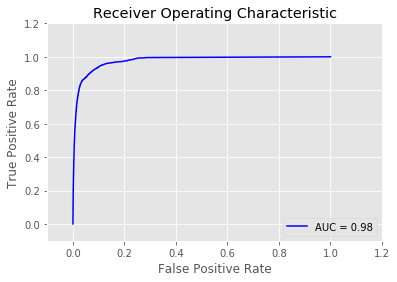

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's l2: 0.00770558	train's auc: 0.984513	valid's l2: 0.00856539	valid's auc: 0.975361
[100]	train's l2: 0.00739782	train's auc: 0.985818	valid's l2: 0.00833039	valid's auc: 0.972887
[150]	train's l2: 0.00718808	train's auc: 0.986275	valid's l2: 0.00815116	valid's auc: 0.971625
[200]	train's l2: 0.00688345	train's auc: 0.987113	valid's l2: 0.00790746	valid's auc: 0.971256
[250]	train's l2: 0.0066853	train's auc: 0.987482	valid's l2: 0.00775728	valid's auc: 0.971764
[300]	train's l2: 0.00653575	train's auc: 0.988148	valid's l2: 0.00767911	valid's auc: 0.971504
[350]	train's l2: 0.0064797	train's auc: 0.988793	valid's l2: 0.00764957	valid's auc: 0.971241
[400]	train's l2: 0.00633702	train's auc: 0.989209	valid's l2: 0.00756939	valid's auc: 0.971158
[450]	train's l2: 0.00623263	train's auc: 0.989672	valid's l2: 0.00753609	valid's auc: 0.971535
[500]	train's l2: 0.00617047	train's auc: 0.9

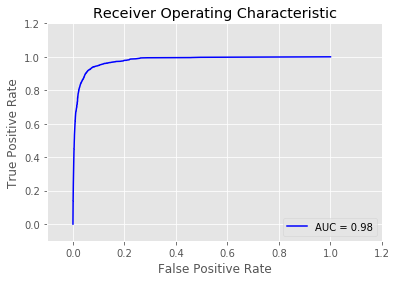

In [38]:
model_pos,score_pos = model_validation(train_df,val_df,predictors,'Normal',{})
model_neg,score_neg = model_validation(train_df,val_df,predictors,'Fraud',{})

In [16]:
model_pos

In [8]:
val_pos = model_pos.predict(val_df[predictors],num_iteration=model_pos.best_iteration)
val_neg = model_neg.predict(val_df[predictors],num_iteration=model_neg.best_iteration)
val_r=pd.DataFrame()
val_r['score_pos'] = 1-val_pos
val_r['score_neg'] = val_neg


Ant-Score: 0.19485818292128015


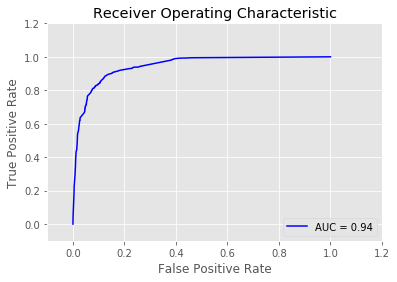

In [9]:
val_r['score'] = val_r['score_pos']*0.1  + val_r['score_neg'] *0.9
a,b,c = atecml.data.accuracy_validation(val_df['Fraud'],val_r['score'])

In [ ]:
test_df = atecml.data.load_test()
y_proba_pos = model_pos.predict(test_df[predictors],num_iteration=model_pos.best_iteration)
y_proba_neg = model_neg.predict(test_df[predictors],num_iteration=model_neg.best_iteration)

In [ ]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score_pos'] = 1-y_proba_pos
result['score_neg'] = y_proba_neg
result['score'] = result['score_pos']*0.1  + result['score_neg'] *0.9

In [ ]:
result[['id','score']].to_csv('./submit_2018_06_26_02.csv',index=False)